In [1]:
import gym
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
import sys
from collections import Counter
from collections import defaultdict

https://zhuanlan.zhihu.com/p/106328516
https://github.com/udacity/deep-reinforcement-learning/blob/master/cheatsheet/cheatsheet.pdf
https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py
https://vmayoral.github.io/robots,/ai,/deep/learning,/rl,/reinforcement/learning/2016/07/10/rl-tutorial/#:~:text=alpha%3A%20is%20the%20the%20learning,set%20between%200%20and%201.
https://towardsdatascience.com/reinforcement-learning-solving-blackjack-5e31a7fb371f

### Часть первая, с блекджеком и стратегиями

Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [23]:
env = gym.make("Blackjack-v0", natural=False)

In [3]:
NUM_ITERATIONS = 10 ** 5

N_player = np.zeros(22)
return_sums_player = np.zeros(22)
N_dealer = np.zeros(22)
return_sums_dealer = np.zeros(22)

for i in tqdm_notebook(range(NUM_ITERATIONS)):
    sum_player, dealer_card, _ = env.reset()
    done = False
    states_player = [sum_player]
    while not done:
        if sum_player < 19:
            (sum_player, dealer_card, _), reward, done, _ = env.step(1)
            if not done:
                states_player.append(sum_player)
        else:
            (sum_player, dealer_card, _), reward, done, _ = env.step(0)
        
    for s in states_player:
        return_sums_player[s] += reward
        N_player[s] += 1
        
    N_dealer[dealer_card] += 1
    return_sums_dealer[dealer_card] += reward
        
    
        
        

<ipython-input-3-d88ec909fb04>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(NUM_ITERATIONS)):


In [4]:
V_player = return_sums_player / N_player
V_dealer = return_sums_dealer / N_dealer

<ipython-input-4-a6d06764fe9d>:1: RuntimeWarning: invalid value encountered in true_divide
  V_player = return_sums_player / N_player
<ipython-input-4-a6d06764fe9d>:2: RuntimeWarning: invalid value encountered in true_divide
  V_dealer = return_sums_dealer / N_dealer


Text(0, 0.5, 'Reward')

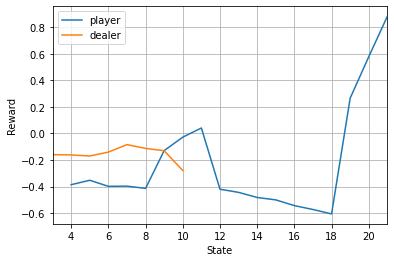

In [5]:
plt.plot(range(22), V_player)
plt.plot(range(22), V_dealer)
plt.grid(True)
plt.xlim(3, 21)
plt.legend(["player", "dealer"])
plt.xlabel("State")
plt.ylabel("Reward")

Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.

In [9]:
def get_action(Q, state, eps):
    if np.random.rand() > eps:
        return np.argmax(Q[state])
    return np.random.choice(env.action_space.n)

def update_Q_(Q, state, next_state, action):
    next_action = np.argmax(Q[next_state])
    Q[state][action] = Q[state][action] + ALPHA * (reward + GAMMA * Q[next_state][next_action] - Q[state][action])

In [28]:
def conduct_experiments(Q, env, iterations=100):
    Rs = []
    for i in range(iterations):
        state = env.reset()
        done = False
        while not done:
            action = get_action(Q, state, 0)
            next_state, reward, done, _ = env.step(action)
            state = next_state

        Rs.append(reward)
    return np.mean(Rs)

Q-learning

In [10]:
NUM_EPISODES = 10 ** 6
DEFAULT_VALUE = 1
ALPHA = 0.4
GAMMA = 1
EPSILON = 1

# key: tuple(player, dealer, usable_ace), value: action(0, 1)
Rs = []
Q = defaultdict(lambda: [-1, -1])
for i in tqdm_notebook(range(NUM_EPISODES)):
    if not i % 1000:
        Rs.append(conduct_experiments(Q, env, 10 ** 4))
    state = env.reset()
    done = False
    while not done:
        eps = max(0.01, EPSILON / (i + 1))
        action = get_action(Q, state, eps)
        next_state, reward, done, _ = env.step(action)
        if done:
            gamma = GAMMA
            GAMMA = 0
        update_Q_(Q, state, next_state, action)
        GAMMA = gamma
        state = next_state        

<ipython-input-10-0cbfa317606b>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(NUM_EPISODES)):


Q-learning

Text(0.5, 1.0, 'Q-learning')

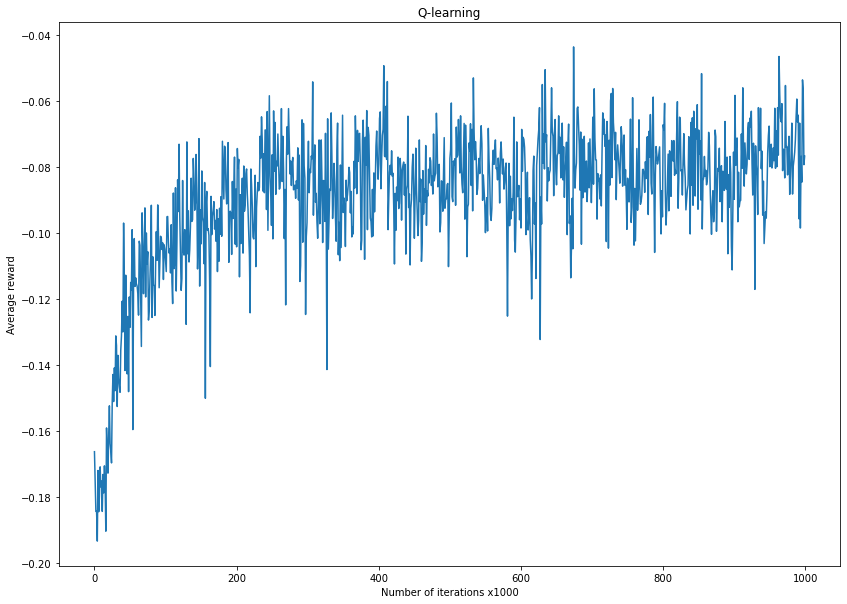

In [11]:
plt.figure(figsize=(14,10))
plt.plot(Rs)
plt.xlabel("Number of iterations х1000")
plt.ylabel("Average reward")
plt.title("Q-learning")

Чтобы я не делал, не получается обучить Q-learning, чтобы он работал лучше, чем эвристика. Не могу понять, почему. День убил на Q-learning. Даже реализовал double Q-learning. Ничего не работает.

Еле-еле получилось завести Q-learning, чтобы получился красивый график. Как оказалось начальные значения в Q тоже имеют значение. Все-таки, если ставить 0, то это не равновесное состояние. 0 - это очень даже хороший результат. Поэтому с него не стоит начинать. Пробовал double q-learning. Он не завелся после кучи попыток.

Не буду врать, ниже взял реализацию Монте-Карло с этого ноутбука https://colab.research.google.com/drive/1zVdv5KRmWyoYZGt83QTGxPkY1Gm7WjDM#scrollTo=FO61u8a1fnTn
Думаю, свои баллы выстрадал уже за Q-learning

In [31]:
def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            Rs_monte_carlo.append(conduct_experiments(Q, env, 10 ** 4))
        # set the value of epsilon
        epsilon = max(epsilon*eps_decay, eps_min)
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        # update the action-value function estimate using the episode
        Q = update_Q(env, episode, Q, alpha, gamma)
    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q

def generate_episode_from_Q(env, Q, epsilon, nA):
    # generates an episode from following the epsilon-greedy policy
    episode = []
    state = env.reset()
#     advantage = card_counter[0] // ((len(shoe) + 15) / 52)
#     advantage = get_nearest(advantage)
#     state = state + (advantage,)
    while True:
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) \
                                    if state in Q else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
#         advantage = card_counter[0] // ((len(shoe) + 15) / 52)
#         advantage = get_nearest(advantage)
#         next_state = next_state + (advantage,)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

def update_Q(env, episode, Q, alpha, gamma):
    # updates the action-value function estimate using the most recent episode 
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]] 
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    return Q

def get_probs(Q_s, epsilon, nA): #nA is no. of actions in the action space
    # obtains the action probabilities corresponding to epsilon-greedy policy
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

In [32]:
Rs_monte_carlo = []
policy, Q = mc_control(env, 10 ** 6, 0.015)

Episode 1000000/1000000.

Text(0.5, 1.0, 'Monte-Carlo')

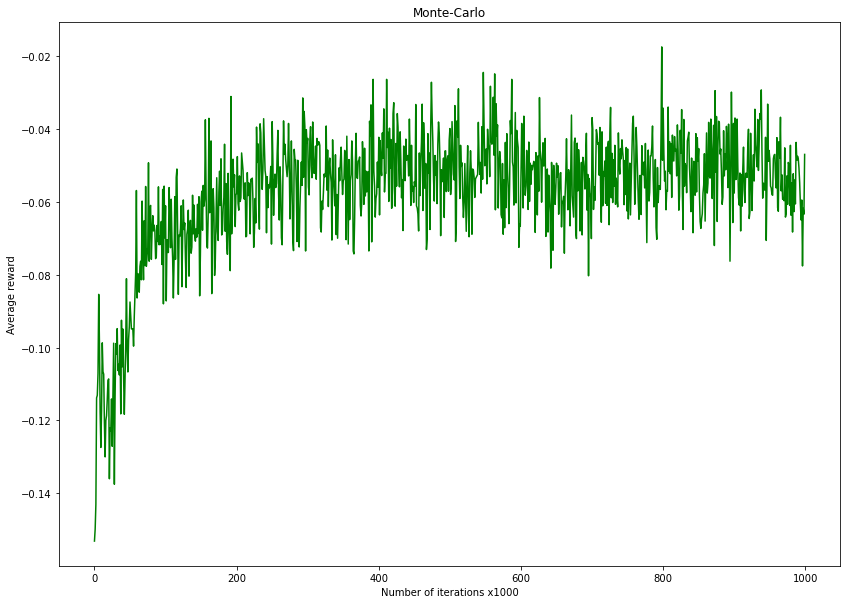

In [33]:
plt.figure(figsize=(14,10))
plt.plot(Rs_monte_carlo, color='g')
plt.xlabel("Number of iterations х1000")
plt.ylabel("Average reward")
plt.title("Monte-Carlo")

In [36]:
conduct_experiments(Q, env, 10 ** 6)

-0.060007

Сравнение различных результатов:
- Q-learning, в том числе Double Q-learning показывает результаты на уровне эвристики всегда говори stand и надейся, что дилер сам ошибется а именно -0.18
- Эвристика всегда говори hit, если меньше 12, дает -0.1
- Эвристика hit, если меньше 15, дает -0.074
- Эвристика говори hit, если меньше 19, -0.2
- Монте-Карло дает -0.05

### Часть 2

In [34]:
from gym import spaces

class EnvExtended(gym.envs.toy_text.blackjack.BlackjackEnv):
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(3)))
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        # Start the first game
        self.reset()
        
    def step(self, action):
        assert action in [0,1,2]
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        else:  # stick: play out the dealers hand, and score
            done = True
            if action == 2:
                self.player.append(draw_card(self.np_random))
                if is_bust(self.player):
                    reward = -2.
                    return self._get_obs(), reward, done, {}
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
            if action == 2:
                reward *= 2
        return self._get_obs(), reward, done, {}
    
    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        return self._get_obs()

    
    
def cmp(a, b):
    return float(a > b) - float(a < b)

# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card(np_random):
    return int(np_random.choice(deck))


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)

In [35]:
env = EnvExtended()

In [980]:
NUM_EPISODES = 10 ** 6
DEFAULT_VALUE = 1
ALPHA = 0.4
GAMMA = 1
EPSILON = 1

# key: tuple(player, dealer, usable_ace), value: action(0, 1)
Gs = [0]
Rs = []
Q = defaultdict(lambda: [-1, -1, -1])
for i in tqdm_notebook(range(NUM_EPISODES)):
    if not i % 1000:
        Rs.append(conduct_experiments(Q, env, 10 ** 4))
    state = env.reset()
    done = False
    while not done:
        eps = max(0.01, EPSILON / (i + 1))
        action = get_action_(Q, state, eps)
        next_state, reward, done, _ = env.step(action)
        if done:
            gamma = GAMMA
            GAMMA = 0
        update_Q_(Q, state, next_state, action)
        GAMMA = gamma
        state = next_state        
    Gs.append(Gs[-1] + reward)

<ipython-input-980-421bcb7c94cc>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(NUM_EPISODES)):


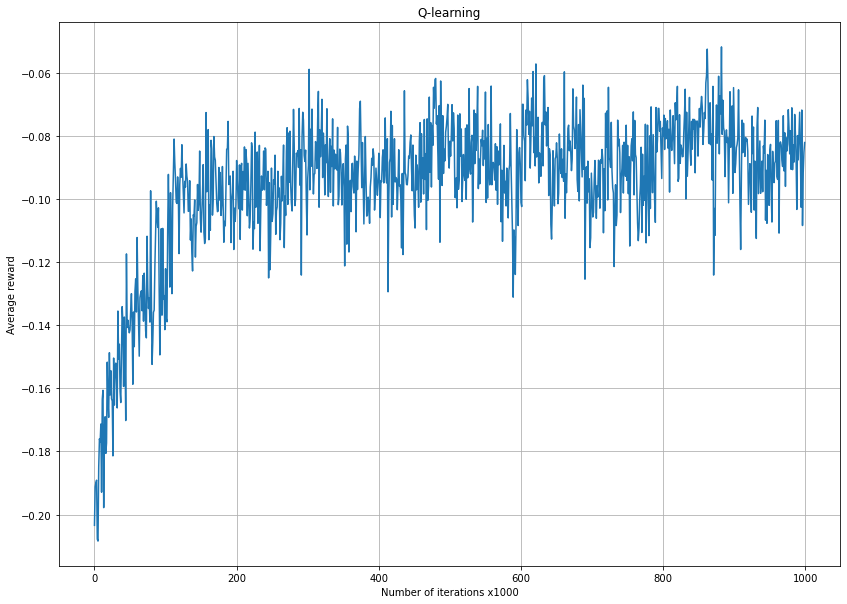

In [982]:
plt.figure(figsize=(14,10))
plt.plot(Rs)
plt.xlabel("Number of iterations х1000")
plt.ylabel("Average reward")
plt.title("Q-learning")
plt.grid()

In [37]:
Rs_monte_carlo = []
policy, Q = mc_control(env, 10 ** 6, 0.015)

Episode 1000000/1000000.

In [38]:
conduct_experiments(Q, env, 10 ** 6)

-0.038295

Text(0.5, 1.0, 'Monte-Carlo')

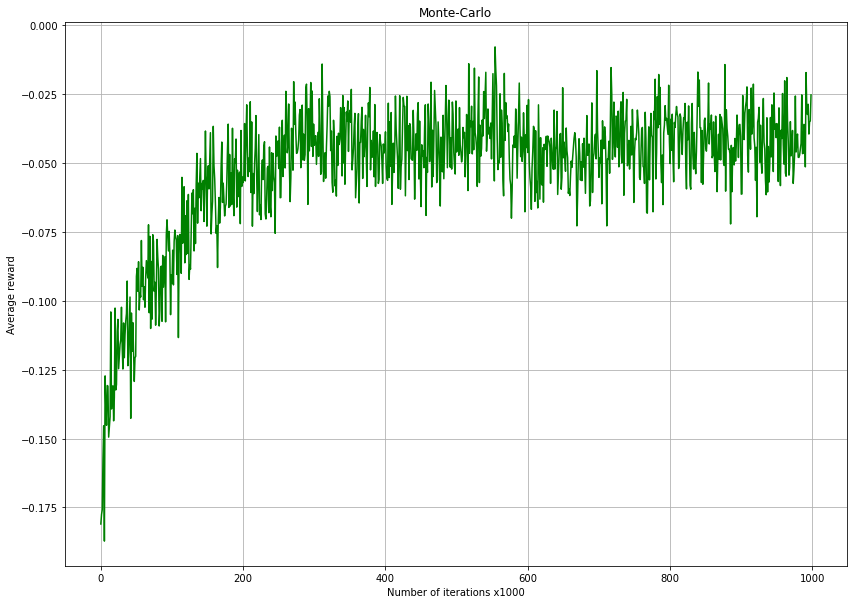

In [39]:
plt.figure(figsize=(14,10))
plt.plot(Rs_monte_carlo[1:], color='g')
plt.xlabel("Number of iterations х1000")
plt.ylabel("Average reward")
plt.grid()
plt.title("Monte-Carlo")

-0.038

### Часть 3

In [43]:
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]
shoe = []

def draw_card(np_random):
    if not shoe:
        shoe.extend(np.random.choice(deck * 4 * 6, 52 * 6 - 15, replace=False))
        card_counter[0] = 0
        
        
    card = shoe.pop()
    card_counter[0] += card_discount(card)
    return card

def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]

def card_discount(card):
    if card in (2, 7):
        return 1
    if card in (3, 4, 6):
        return 2
    if card == 5:
        return 3
    if card == 8:
        return 0
    if card == 9:
        return -1
    # 10, J, Q, K, A
    return -2

def get_nearest(advantage):
    return np.searchsorted([-52, -45, -40, -34, -28, -22, -17, -11,
                            -5, 0, 5, 11, 17, 22, 28, 34, 40, 45, 52], advantage) // 4

def conduct_experiments(Q, env, iterations=100):
    Rs = []
    for i in range(iterations):
        state = env.reset()
        done = False
#         count_state = np.sign(card_counter[0] - 0.01)
        advantage = card_counter[0] // ((len(shoe) + 15) / 52)
        advantage = get_nearest(advantage)
        state = state + (advantage,)
        while not done:
            action = get_action(Q, state, 0)
            next_state, reward, done, _ = env.step(action)
#             count_state = np.sign(card_counter[0] - 0.01)
            advantage = card_counter[0] // ((len(shoe) + 15) / 52)
            advantage = get_nearest(advantage)
            next_state = next_state + (advantage,)
            state = next_state

        Rs.append(reward)
    return np.mean(Rs)

def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 10000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
            Rs_monte_carlo.append(conduct_experiments(Q, env, 10 ** 4))
        # set the value of epsilon
        epsilon = max(epsilon*eps_decay, eps_min)
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        # update the action-value function estimate using the episode
        Q = update_Q(env, episode, Q, alpha, gamma)
    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q

def generate_episode_from_Q(env, Q, epsilon, nA):
    # generates an episode from following the epsilon-greedy policy
    episode = []
    state = env.reset()
    advantage = card_counter[0] // ((len(shoe) + 15) / 52)
    advantage = get_nearest(advantage)
    state = state + (advantage,)
    while True:
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) \
                                    if state in Q else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        advantage = card_counter[0] // ((len(shoe) + 15) / 52)
        advantage = get_nearest(advantage)
        next_state = next_state + (advantage,)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [41]:
card_strategy = ["+1", "+2", "+2", "+3", "+2", "+1", 0, "-1", "-2", "-2"]
card_strategy = pd.DataFrame([card_strategy])
card_strategy.columns = [2, 3, 4, 5, 6, 7, 8, 9, "10, J, Q, K", "A"]
card_strategy

,2,3,4,5,6,7,8,9,"10, J, Q, K",A
0,+1,+2,+2,+3,+2,+1,0,-1,-2,-2


In [47]:
NUM_EPISODES = 10 ** 7
DEFAULT_VALUE = 1
ALPHA = 0.4
GAMMA = 1
EPSILON = 1

# key: tuple(player, dealer, usable_ace), value: action(0, 1)
Gs = [0]
Rs = []
Q = defaultdict(lambda: [-1, -1, -1])
card_counter = [0]
shoe = []
for i in tqdm_notebook(range(NUM_EPISODES)):
    if not i % 1000:
        Rs.append(conduct_experiments(Q, env, 10 ** 4))
    state = env.reset()
    count_state = np.sign(card_counter[0] - 0.01)
    state = state + (count_state,)
    done = False
    while not done:
        eps = max(0.01, EPSILON / (i + 1))
        action = get_action(Q, state, eps)
        next_state, reward, done, _ = env.step(action)
        count_state = np.sign(card_counter[0] - 0.01)
        next_state = next_state + (count_state,)
        if done:
            gamma = GAMMA
            GAMMA = 0
        update_Q_(Q, state, next_state, action)
        GAMMA = gamma
        state = next_state        
    Gs.append(Gs[-1] + reward)

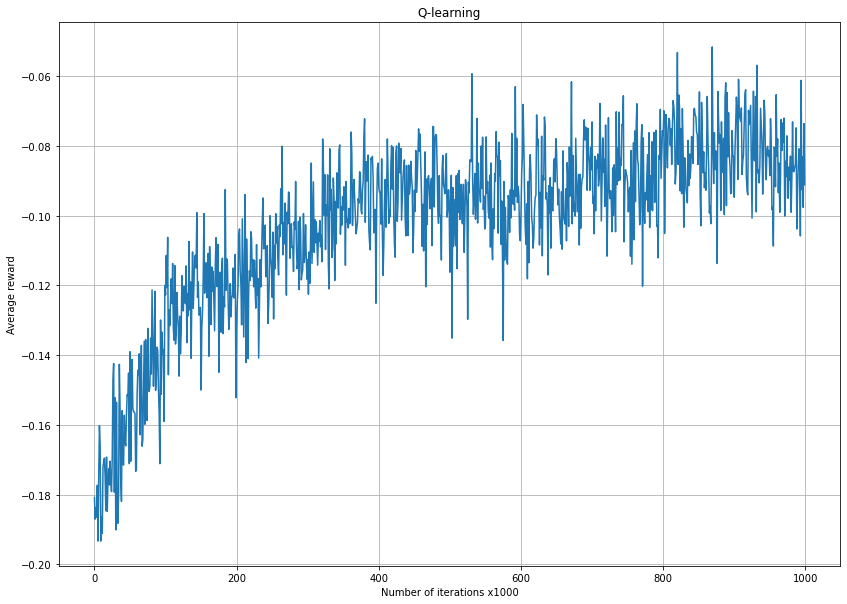

In [1154]:
plt.figure(figsize=(14,10))
plt.plot(Rs)
plt.xlabel("Number of iterations х1000")
plt.ylabel("Average reward")
plt.title("Q-learning")
plt.grid()

In [44]:
Rs_monte_carlo = []
policy, Q = mc_control(env, 10 ** 7, 0.015)

Episode 10000000/10000000.

In [46]:
conduct_experiments(Q, env, 10 ** 6)

-0.04209

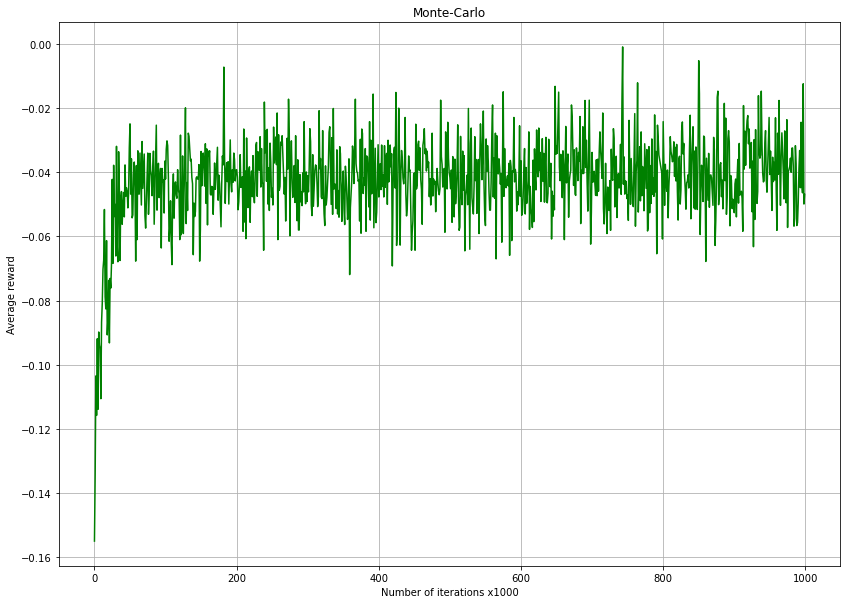

In [45]:
plt.figure(figsize=(14,10))
plt.plot(Rs_monte_carlo, color='g')
plt.xlabel("Number of iterations х1000")
plt.ylabel("Average reward")
plt.title("Monte-Carlo")
# plt.ylim(-0.2, 0)
plt.grid()